In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['savefig.dpi'] = 300
from matplotlib import cm

import seaborn as sns

from tqdm.auto import tqdm

import os
import ctypes
import gc

In [2]:
#  https://stackoverflow.com/a/37664693/13213091

def wrapped_ndptr(*args, **kwargs):
    base = np.ctypeslib.ndpointer(*args, **kwargs)
    def from_param(cls, obj):
        if obj is None:
            return obj
        return base.from_param(obj)
    return type(base.__name__, (base,), {'from_param': classmethod(from_param)})

DoubleArrayType_1D = wrapped_ndptr(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
DoubleArrayType_2D = wrapped_ndptr(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS')

In [3]:
dirname = '../src/model_ctypes/_koivumaki/'
filename_so = os.path.join(dirname, 'koivumaki.so')

filename_so_abs = os.path.abspath(filename_so)

model = ctypes.CDLL(filename_so_abs)

model.initialize_states_default.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]

model.initialize_states_default.restype = ctypes.c_void_p


model.run.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'), # double *S
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'), # double *C
    ctypes.c_int, # int n_beats
    ctypes.c_double, # double t_sampling
    ctypes.c_double, # double tol
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS'), # double *output
    
    DoubleArrayType_2D, #np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS'), # double *output_A
    DoubleArrayType_1D, #np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS') # double *output_t
    DoubleArrayType_1D, # double *stim_protocol
]

model.run.restype = ctypes.c_int


model.compute_rates_algebraic.argtypes = [
    ctypes.c_double, # double time
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'), # double *S
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'), # double *C
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'), # double *A
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS') # double *R
]

model.compute_rates_algebraic.restype = ctypes.c_void_p


def run(S, C, n_beats, t_sampling, tol, output, *,
        output_A=None, t=None, stim_protocol=None):
    
    return model.run(S, C, n_beats, t_sampling, tol, output, output_A, t, stim_protocol)


legend_constants = pd.read_csv(os.path.join(dirname, "legend_constants.csv"), index_col='name')['value']
legend_states = pd.read_csv(os.path.join(dirname, "legend_states.csv"), index_col='name')['value']
legend_algebraic = pd.read_csv(os.path.join(dirname, "legend_algebraic.csv"), index_col='name')
legend_algebraic['value'] = 0.0
legend_algebraic = legend_algebraic['value']

# model.initialize_states_default(legend_states.values, legend_constants.values)
# legend_states.to_csv(os.path.join(dirname, "legend_states.csv"))

In [4]:
S = legend_states.copy()
R = S * 0
C = legend_constants.copy()
A = legend_algebraic.copy()

In [5]:
args = 0.0, S.values, C.values, A.values, R.values

In [ ]:
%%timeit
model.compute_rates_algebraic(*args)

In [66]:
def fun(t, S):
    
    STIM = (t % C['STIM_PERIOD'] <= 0.001)
    C.iloc[82] = 1 if STIM else C.iloc[92]
    A.iloc[56] = C.iloc[82] * C.iloc[34]  
                
    model.compute_rates_algebraic(t, S, C.values, A.values, R.values)

    return R.values

In [67]:
#CL = 1000

#C['CL'] = CL / 1000
#C['STIM_PERIOD'] = 0.25
n_beats = 1
stim_period = C['STIM_PERIOD']
t_sampling = 1.

t_space = np.linspace(0, stim_period * n_beats, int(stim_period / t_sampling) * n_beats + 1, endpoint=True)
t_span = 0, t_space[-1]

In [68]:
from scipy.integrate import solve_ivp

In [74]:
%%time
sol = solve_ivp(fun, y0=S.values,
                t_span=t_span,# t_eval=t_space,
                method = 'LSODA', # atol=atol, # rtol=1e-3,
                #max_step=1. * t_sampling,
                )

CPU times: user 1.93 s, sys: 1.18 s, total: 3.1 s
Wall time: 994 ms


In [70]:
t, y = sol.t, sol.y
output = pd.DataFrame(y.T, columns=legend_states.index)

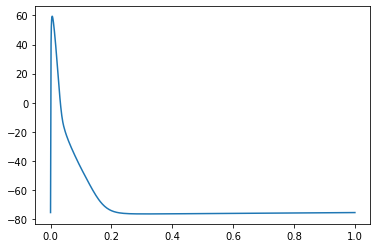

In [71]:
plt.plot(t, output.V)

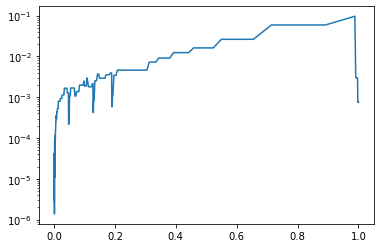

In [72]:
plt.semilogy(t[1:], np.diff(t))

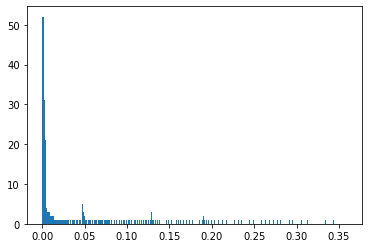

In [73]:
plt.hist(t, bins=np.arange(len(t)) / 1000);

In [18]:
t_sampling = 0.001

CL = 250
C['STIM_PERIOD'] = CL / 1000
stim_period = C['STIM_PERIOD']
n_samples_per_stim = int(stim_period / t_sampling)

n_beats = 1
tol = 1e-3

In [14]:
C['G_seal'] = 0.0
C['fluo_tot'] = 0.0

In [8]:
#stim_protocol = np.zeros(n_samples_per_stim)

stim_protocol = np.random.randn(4500) * 0#5.76

stim_protocol[1] = 2500

# stim_protocol = pd.read_csv("../data/voigt/G1/C1/phenotypes/phenotype_1032_raw.csv")['Ist'].values

In [9]:
# pd.DataFrame(-stim_protocol, columns=['Ist']).to_csv("../data/koivumaki/stim_protocol.csv", index=False)

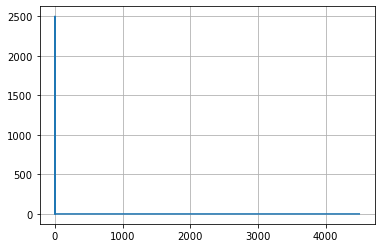

In [10]:
plt.plot(stim_protocol)
plt.grid()

In [11]:
# C['STIM_LEVEL'] = 0.5

In [97]:
S = S_400.copy()

In [98]:
%%time

output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))
output_A = np.zeros((n_samples_per_stim * n_beats + 1, len(A)))
t = np.zeros(n_samples_per_stim * n_beats + 1)

status = run(S.values.copy(), C.values.copy(),
             n_beats, t_sampling, tol, output,
             output_A=output_A, stim_protocol=stim_protocol,
             )

print(status)

output = pd.DataFrame(output, columns=legend_states.index)
output_A = pd.DataFrame(output_A, columns=legend_algebraic.index)

2
CPU times: user 814 ms, sys: 39.4 ms, total: 853 ms
Wall time: 871 ms


In [19]:
output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))


In [ ]:
%%timeit

model.compute_rates_algebraic()

In [20]:
%%timeit

status = run(S.values.copy(), C.values.copy(),
             n_beats, t_sampling, tol, output,
             )

3.12 ms ± 1.87 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


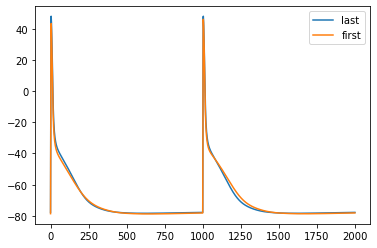

In [104]:
plt.plot(output.V.iloc[-2 * CL - 1:].values, label='last')
plt.plot(output.V.iloc[:2 * CL + 1].values, label='first')

plt.legend()

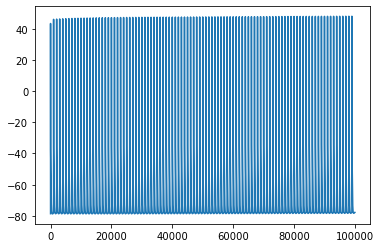

In [100]:
plt.plot(output.V)

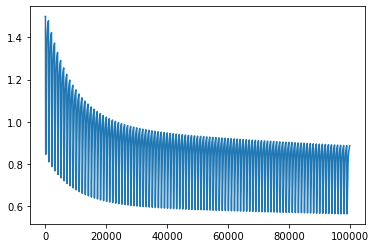

In [101]:
plt.plot(output.CaSR)

In [82]:
# S_400 = output.iloc[-1].copy()

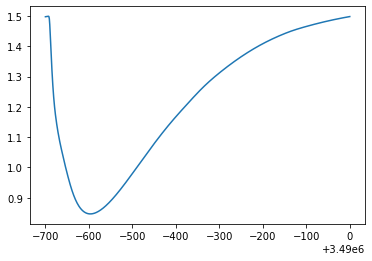

In [81]:
plt.plot(output.CaSR[-2 * CL - 1:])

In [79]:
output.iloc[-1]

name
CaSR1        1.606935e+00
CaSR2        1.572989e+00
CaSR3        1.514224e+00
CaSR4        1.439951e+00
Cai1         3.189438e-04
Cai2         3.255285e-04
Cai3         3.417122e-04
Cai4         3.768000e-04
Cass         3.863675e-04
d            6.154178e-06
f1           9.991132e-01
f2           9.934589e-01
fca          8.693709e-01
y            2.542826e-02
pa           6.343422e-05
n            1.542322e-02
ikur_r       2.163684e-04
ikur_s       9.438383e-01
h1           9.426411e-01
h2           8.139170e-01
m            1.888760e-03
it_r         7.198872e-04
it_s         9.647132e-01
V           -7.859630e+01
Ki           1.321275e+02
ryr_a1       4.359614e-01
ryr_a2       4.477842e-01
ryr_a3       4.658324e-01
ryr_ass      4.878860e-01
c1           9.703998e-01
c2           9.444620e-01
c3           8.973532e-01
css          9.997075e-01
o1           1.456303e-05
o2           1.271947e-05
o3           1.344971e-05
oss          2.446170e-05
serca_a1     1.857585e-02
serca_a

In [144]:
#%timeit status = run(S.values.copy(), C.values.copy(), n_beats, t_sampling, tol, output)

In [145]:
output.head()

name,CaSR1,CaSR2,CaSR3,CaSR4,Cai1,Cai2,Cai3,Cai4,Cass,d,...,Nai,Nass,fluo_1,fluo_2,fluo_3,fluo_4,fluo_ss,CaSR,Cai,fluo
0,0.618923,0.607629,0.590527,0.573811,0.000135,0.000138,0.000144,0.000156,0.000162,0.000011,...,9.286860,8.691504,0.000000,0.000000,0.000000,0.000000,0.000000,0.588195,0.000148,0.000000
1,0.618883,0.607611,0.590547,0.573873,0.000020,0.000020,0.000021,0.000023,0.000024,0.002358,...,9.286853,8.753782,0.000116,0.000118,0.000124,0.000134,0.000139,0.588223,0.000022,0.000127
2,0.618842,0.607591,0.590566,0.573936,0.000011,0.000011,0.000011,0.000012,0.000034,0.355429,...,9.286852,9.339540,0.000126,0.000129,0.000134,0.000145,0.000171,0.588250,0.000012,0.000137
3,0.618801,0.607571,0.590585,0.573998,0.000010,0.000010,0.000011,0.000012,0.000054,0.608955,...,9.286853,9.362587,0.000128,0.000130,0.000136,0.000147,0.000239,0.588277,0.000011,0.000140
4,0.618759,0.607550,0.590602,0.574061,0.000010,0.000010,0.000011,0.000012,0.000066,0.762800,...,9.286854,9.356060,0.000128,0.000131,0.000136,0.000149,0.000327,0.588303,0.000012,0.000142


In [146]:
output_A

name,I_calcium_CaSR4_beta,I_calcium_Cai3_gamma,I_calcium_Cass_i_tot,I_calcium_CaSR1_beta,I_calcium_Cai2_gamma,I_calcium_CaSR3_beta,I_calcium_Cai1_gamma,I_calcium_CaSR2_beta,I_calcium_Cai4_gamma,I_calcium_Cai2_beta,...,I_ECa,I_INa,I_IKs,I_IKr,I_IfK,I_IK1,I_It,I_EK,I_If,I_Iseal
0,0.260420,8.964740,2.482216,0.273057,9.007987,0.265106,9.026944,0.269896,8.880278,0.099920,...,122.879363,-0.001319,0.038689,0.000138,0.387484,22.196724,0.070466,-84.841934,-1.821207,-0.075428
1,0.260437,9.907916,35.999029,0.273046,9.915207,0.265111,9.918382,0.269891,9.895622,0.091615,...,147.959919,-4476.270936,0.274104,0.001118,2.737990,8.813557,4.355698,-84.842561,1.394594,-0.018236
2,0.260455,9.988822,826.657944,0.273034,9.992652,0.265117,9.994310,0.269885,9.981322,0.090970,...,143.317119,-446.293488,0.629672,0.024253,4.479944,0.459326,272.982346,-84.842523,4.184664,0.045894
3,0.260473,9.995098,1090.848737,0.273023,9.998685,0.265122,10.000204,0.269880,9.983501,0.090920,...,137.455574,-133.202618,0.845648,0.040057,2.825707,0.297014,562.077929,-84.842358,2.716987,0.054713
4,0.260490,9.995144,1158.395266,0.273011,9.998775,0.265127,10.000277,0.269874,9.979747,0.090919,...,134.778529,-69.434497,1.056788,0.054613,1.383284,0.249801,699.255495,-84.842125,1.343588,0.058191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0.356193,8.439289,-5.017445,0.361615,8.515820,0.359966,8.555487,0.361311,8.312772,0.105088,...,117.459932,-0.001847,0.078495,0.000180,0.381691,23.608432,0.085065,-84.818878,-1.552544,-0.074413
9997,0.356193,8.439289,-5.017445,0.361615,8.515820,0.359966,8.555487,0.361311,8.312772,0.105088,...,117.459932,-0.001847,0.078495,0.000180,0.381691,23.608432,0.085065,-84.818878,-1.552544,-0.074413
9998,0.356193,8.439289,-5.017445,0.361615,8.515820,0.359966,8.555487,0.361311,8.312772,0.105088,...,117.459932,-0.001847,0.078495,0.000180,0.381691,23.608432,0.085065,-84.818878,-1.552544,-0.074413
9999,0.356193,8.439289,-5.017445,0.361615,8.515820,0.359966,8.555487,0.361311,8.312772,0.105088,...,117.459932,-0.001847,0.078495,0.000180,0.381691,23.608432,0.085065,-84.818878,-1.552544,-0.074413


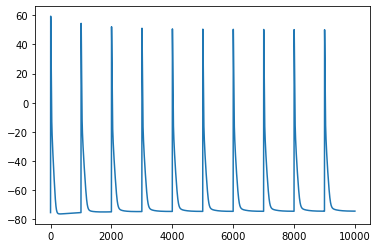

In [147]:
plt.plot(output.V[:])

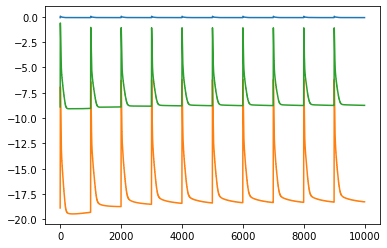

In [148]:
plt.plot(output_A.I_Iseal)
plt.plot(output_A.I_ICab)
plt.plot(output_A.I_INab)

In [9]:
keys = 'I_JSRCaleak1', 'I_J_SERCASR1', 'I_J_bulkSERCA1', 'I_JSRCa1', 'I_Jrel1'

for key in keys:
    plt.plot(output_A[key], label=key)
    
plt.legend()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

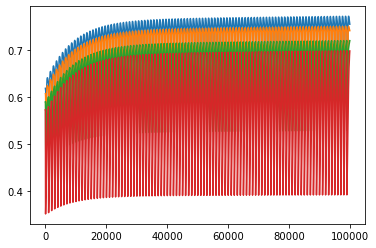

In [12]:
for i in range(4):
    plt.plot(output[f'CaSR{i + 1}'])

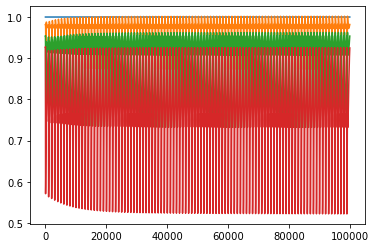

In [13]:
for i in range(4):
    plt.plot(output[f'CaSR{i + 1}'] / output[f'CaSR{0 + 1}'])

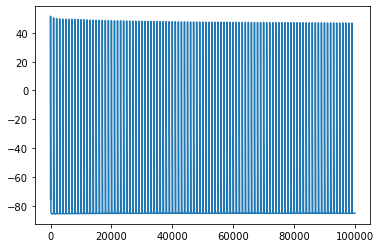

In [20]:
plt.plot(output.V)

In [15]:
CL_list = [2000, 1000, 666, 500]

dirname = "../data/koivumaki/fluo/"

for CL in tqdm(CL_list):
    
    C['fluo_tot'] = 0.001 # mM
    model.initialize_states_default(S.values, C.values)    
    
    t_sampling = 0.001
    
    C['STIM_PERIOD'] = CL / 1000
    stim_period = C['STIM_PERIOD']
    n_samples_per_stim = int(stim_period / t_sampling)

    n_beats = int(1000 * 1000 / CL)
    tol = 1e-6

    output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))
#     output_A = np.zeros((n_samples_per_stim * n_beats + 1, len(A)))
#     t = np.zeros(n_samples_per_stim * n_beats + 1)
    
#     status = model.run_algebraic(S.values.copy(), C.values.copy(),
#                                  n_beats, t_sampling, tol, output,
#                                  output_A, t)
    
    status = model.run(S.values.copy(), C.values.copy(),
                   n_beats, t_sampling, tol, output)

    print(status)
    
    output = pd.DataFrame(output, columns=legend_states.index)
#     output_A = pd.DataFrame(output_A, columns=legend_algebraic.index)
    
    phenotype = output[-CL - 1:][:1000]
    
    # phenotype[['fluo_1', 'fluo_2', 'fluo_3', 'fluo_4', 'fluo_ss']] *= 0
    
    state = phenotype.iloc[-1].values
    
    phenotype.to_csv(os.path.join(dirname, 'phenotypes', f'phenotype_{CL}.csv'), index=False)
    np.savetxt(os.path.join(dirname, 'states', f'state_{CL}.txt'), state)

  0%|          | 0/4 [00:00<?, ?it/s]

2
2
2
2


In [16]:
atol = (output.abs().min() / 10).clip(lower=1e-6, upper=1e-3)
atol = np.power(10, np.log10(atol).round())

s = ""
for i, name in enumerate(atol.index):
    x = f'/*{name}*/ {atol[name]}, '
    s += x
    s += (20 - len(x)) * ' '
    if i % 5 == 4:
        s += '\n'

In [17]:
print(s)

/*CaSR1*/ 0.001,    /*CaSR2*/ 0.001,    /*CaSR3*/ 0.001,    /*CaSR4*/ 0.001,    /*Cai1*/ 1e-05,     
/*Cai2*/ 1e-05,     /*Cai3*/ 1e-05,     /*Cai4*/ 1e-05,     /*Cass*/ 1e-05,     /*d*/ 1e-06,        
/*f1*/ 0.001,       /*f2*/ 0.001,       /*fca*/ 0.001,      /*y*/ 0.0001,       /*pa*/ 1e-06,       
/*n*/ 0.001,        /*ikur_r*/ 1e-05,   /*ikur_s*/ 0.001,   /*h1*/ 1e-06,       /*h2*/ 1e-05,       
/*m*/ 0.0001,       /*it_r*/ 0.0001,    /*it_s*/ 0.001,     /*V*/ 0.0001,       /*Ki*/ 0.001,       
/*ryr_a1*/ 0.001,   /*ryr_a2*/ 0.001,   /*ryr_a3*/ 0.001,   /*ryr_ass*/ 0.001,  /*c1*/ 0.001,       
/*c2*/ 0.001,       /*c3*/ 0.001,       /*css*/ 1e-06,      /*o1*/ 1e-06,       /*o2*/ 1e-06,       
/*o3*/ 1e-06,       /*oss*/ 1e-06,      /*serca_a1*/ 0.001, /*serca_a2*/ 0.001, /*serca_a3*/ 0.001, 
/*serca_ass*/ 0.001, /*Nai*/ 0.001,      /*Nass*/ 0.001,     /*fluo_1*/ 1e-05,   /*fluo_2*/ 1e-05,   
/*fluo_3*/ 1e-05,   /*fluo_4*/ 1e-05,   /*fluo_ss*/ 1e-05,  /*CaSR*/ 0.001,     /*Cai*/ 1e

  0%|          | 0/4 [00:00<?, ?it/s]

Nai       8.771444
Ki      135.500175
CaSR      0.720163
fluo      0.000187
Name: 999, dtype: float64
Nai      10.319751
Ki      134.276020
CaSR      0.740165
fluo      0.000195
Name: 999, dtype: float64
Nai      11.971390
Ki      132.897933
CaSR      0.797142
fluo      0.000244
Name: 666, dtype: float64
Nai      13.309832
Ki      131.807066
CaSR      0.837251
fluo      0.000300
Name: 500, dtype: float64


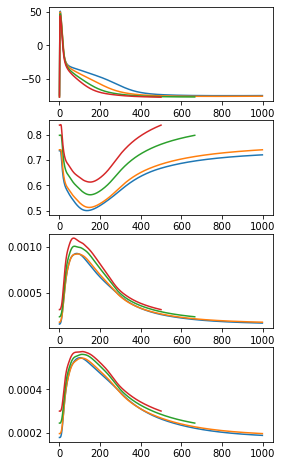

In [18]:
fig, axes = plt.subplots(nrows=4, figsize=plt.figaspect(2))

for stim_period in tqdm([2000, 1000, 666, 500]):
    
    phenotype_filename = os.path.join(dirname, f'phenotypes/phenotype_{stim_period}.csv')
    df = pd.read_csv(phenotype_filename)
    
    axes[0].plot(df.V)
    axes[1].plot(df.CaSR)
    axes[2].plot(df.Cai)
    axes[3].plot(df.fluo)
    
    print(df.iloc[-1][['Nai', 'Ki', 'CaSR', 'fluo']])

In [20]:
states = {}

for CL in CL_list:
    phenotype = pd.read_csv(os.path.join(dirname, 'phenotypes', f'phenotype_{CL}.csv'))
    states[CL] = phenotype.iloc[-1]
    
states = pd.concat(states, axis=1)
#states

,2000,1000,666,500
CaSR1,0.758275,0.779093,0.890323,0.985418
CaSR2,0.744723,0.765250,0.863680,0.951130
CaSR3,0.723522,0.743730,0.813143,0.874374
CaSR4,0.701793,0.721307,0.743885,0.740763
Cai1,0.000159,0.000165,0.000205,0.000253
Cai2,0.000161,0.000168,0.000213,0.000266
Cai3,0.000167,0.000175,0.000229,0.000297
Cai4,0.000177,0.000189,0.000261,0.000361
Cass,0.000181,0.000195,0.000270,0.000377
d,0.000011,0.000009,0.000008,0.000007


# STIM_LEVEL_BASELINE

In [47]:
%matplotlib inline

In [45]:
output_list = []
output_A_list = []

for baseline_multiplier in -np.inf, -60: #  -200, -80, -60, -40, -15:

    C['STIM_LEVEL_BASELINE'] = 1 / baseline_multiplier

    t_sampling = 0.001

    C['STIM_PERIOD'] = 1
    stim_period = C['STIM_PERIOD']
    n_samples_per_stim = int(stim_period / t_sampling)

    n_beats = 100
    tol = 1e-4

    output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))
    output_A = np.zeros((n_samples_per_stim * n_beats + 1, len(A)))
    t = np.zeros(n_samples_per_stim * n_beats + 1)

    status = model.run_algebraic(S.values.copy(), C.values,
                                 n_beats, t_sampling, tol, output,
                                 output_A, t)

    output = pd.DataFrame(output, columns=legend_states.index)
    output_A = pd.DataFrame(output_A, columns=legend_algebraic.index)
    print(status)
    
    plt.plot(output.V[:2000], label=f"{baseline_multiplier}")
    
plt.legend()
    

2
2


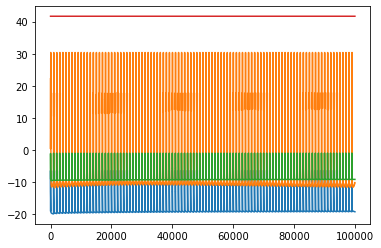

In [55]:
plt.plot(output_A.I_ICab)
plt.plot(output_A.I_IK1)
plt.plot(output_A.I_INab)


plt.plot(output_A.I_i_stim[output_A.I_i_stim > 0])

# Old

In [18]:
rescale = lambda x: (x - np.min(x)) / np.ptp(x)

Text(0, 0.5, 'normalized units')

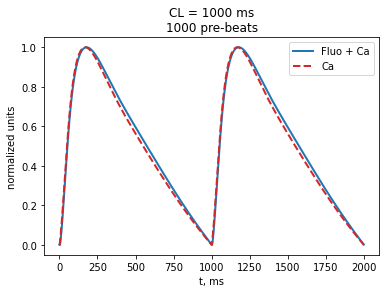

In [19]:
plt.plot(rescale(df.fluo_mean), lw=2, label='Fluo + Ca')
plt.plot(rescale(df.Cai_mean), '--', color='C3', lw=2, label='Ca')

plt.legend()
plt.title('CL = 1000 ms\n1000 pre-beats')
plt.xlabel('t, ms')
plt.ylabel('normalized units')

#plt.savefig("../images/fluo/fluo_ca_shapes.png", dpi=300, facecolor='white')

In [20]:
df[['Cai_mean', 'fluo_mean']].describe().iloc[1:]

name,Cai_mean,fluo_mean
mean,0.000422,0.003618
std,0.000023,0.000125
min,0.000383,0.003410
25%,0.000400,0.003506
50%,0.000421,0.003618
75%,0.000443,0.003732
max,0.000458,0.003806


In [27]:
def Ca(F, F_max=0.01, F_min=0, Kd=0.74e-3): # Kd=0.74e-3
    return Kd * (F - F_min) / (F_max - F)

In [28]:
ca = Ca(df.fluo_mean)

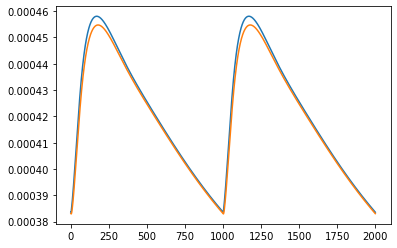

In [29]:
plt.plot(df.Cai_mean)
plt.plot(Ca(df.fluo_mean))

In [82]:
rel_range = np.logspace(-2, 2, 13)# [0.1, 1, 10, 100]

In [5]:
fluo_tot_range = np.hstack([0, np.logspace(-3, 0, 13)])

In [6]:
# columns = 'Cai_mean', 'fluo_mean', 'fluo_rel', 'V'

result = []
result_A = []

# fig, axes = plt.subplots(nrows=len(columns), figsize=plt.figaspect(3), sharex=True)

#fluo_tot_range = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.]

for i, fluo_tot in tqdm(list(enumerate(fluo_tot_range))):
#for i, rel in tqdm(enumerate(rel_range)):
    
    C['fluo_tot'] = fluo_tot
    #C['Jrel_multiplier'] = rel
    #C['J_SERCASR_multiplier'] = rel

    
    model.initialize_states_default(S.values, C.values)
    
    C['STIM_PERIOD'] = 1
    stim_period = C['STIM_PERIOD']
    n_samples_per_stim = int(stim_period / t_sampling)

    n_beats = 1000

    output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))
    output_A = np.zeros((n_samples_per_stim * n_beats + 1, len(A)))
    t = np.zeros(n_samples_per_stim * n_beats + 1)
    
    status = model.run_algebraic(S.values.copy(), C.values.copy(),
                                 n_beats, t_sampling, tol, output,
                                 output_A, t)
    output = output[-1011:]
    output = pd.DataFrame(output, columns=legend_states.index)
    
    output_A = output_A[-1011:]
    output_A = pd.DataFrame(output_A, columns=legend_algebraic.index)
    
    volumes = legend_constants[['Vss'] + [f'Vnonjunct{i}' for i in range(1, 4 + 1)]]

    concentrations = output[['Cass'] + [f'Cai{i}' for i in range(1, 4 + 1)]]
    Cai_mean = (concentrations.values * volumes.values).sum(axis=1) / sum(volumes)

    concentrations = output[['fluo_ss'] + [f'fluo_{i}' for i in range(1, 4 + 1)]]
    fluo_mean = (concentrations.values * volumes.values).sum(axis=1) / sum(volumes)

    output['Cai_mean'] = Cai_mean
    output['fluo_mean'] = fluo_mean
    #output['fluo_rel'] = fluo_mean / fluo_tot * 100
        
    result.append(output.copy())
    result_A.append(output_A.copy())
    
    del output
    del output_A
    gc.collect()

  0%|          | 0/14 [00:00<?, ?it/s]

In [119]:
rel_range[8]

4.6415888336127775

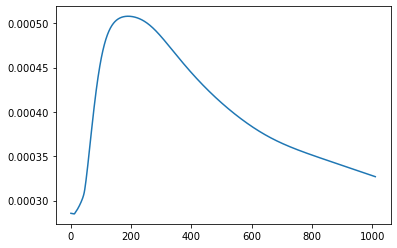

In [120]:
plt.plot(result[8].Cai_mean)

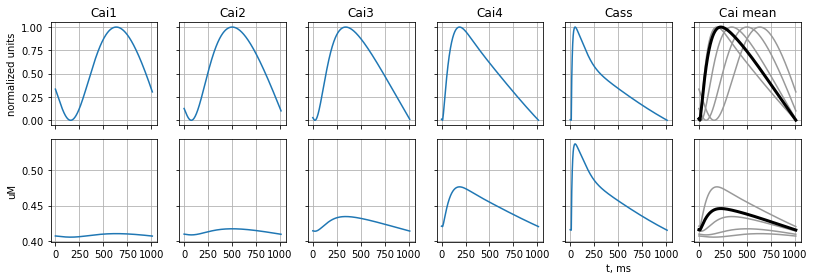

In [82]:
fig, axes = plt.subplots(ncols=6, nrows=2,
                         figsize=plt.figaspect(0.35),
                         sharex=True, sharey='row')

#axes = axes.flatten()

df = result[6]


for i in range(2):
    
    if i == 1:
        rescale = lambda x: x * 1000
    else:
        rescale = lambda x: (x - np.min(x)) / np.ptp(x)

    for j in range(1, 4+1):
        ax = axes[i][j-1]
        key = f'Cai{j}'
        ax.plot(rescale(df[key]))
        axes[i][-1].plot(rescale(df[key]), color='0.6')
        if i == 0:
            ax.set_title(key)

    axes[i][-1].plot(rescale(df.Cai_mean), lw=3, color='k')
    axes[i][-2].plot(rescale(df['Cass']))

    if i == 0:
        axes[i][-1].set_title('Cai mean')
        axes[i][-2].set_title('Cass')
    else:
        axes[i][-2].set_xlabel('t, ms')

    for ax in axes.flatten():
        ax.grid(True)
        ax.set_xticks(np.linspace(0, 1000, 5))
        
axes[0, 0].set_ylabel('normalized units')
axes[1, 0].set_ylabel('uM')

plt.tight_layout()

plt.savefig("../images/fluo/compartments.png", dpi=600)

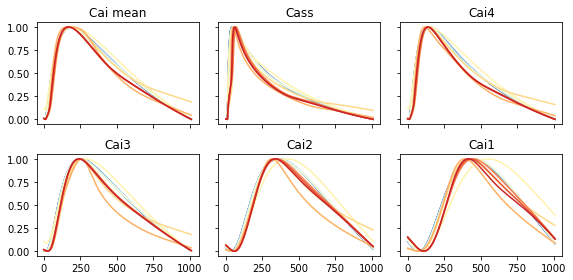

In [103]:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         figsize=plt.figaspect(0.5),
                         sharex=True,
                         sharey=True)

axes = axes.flatten()

cmap = cm.coolwarm
cmap = cm.RdYlBu_r

for i, df in enumerate(result):
    
    rescale = lambda x: (x - np.min(x)) / np.ptp(x)
    #rescale = lambda x: x * 1000
    
    color = cmap(i/len(result))
    
    axes[0].plot(rescale(df.Cai_mean), color=color)
    #axes[0].plot(df.Cai_mean)
    
    axes[1].plot(rescale(df['Cass']), color=color)
    
    for j in range(1, 4+1):
        ax = axes[1+j]
        key = f'Cai{5-j}'
        ax.plot(rescale(df[key]), color=color)
        ax.set_title(key)
        
axes[0].set_title('Cai mean')
axes[1].set_title('Cass')

plt.tight_layout()

plt.savefig("../images/fluo/rel_variation_normalized.png", dpi=600)

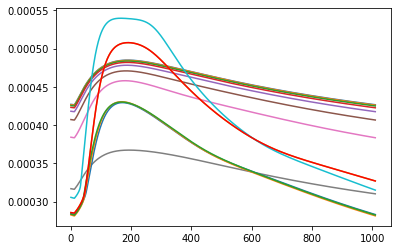

In [117]:
for i, df in enumerate(result):
    plt.plot(df.Cai_mean)
    
plt.plot(result[8].Cai_mean, 'r')

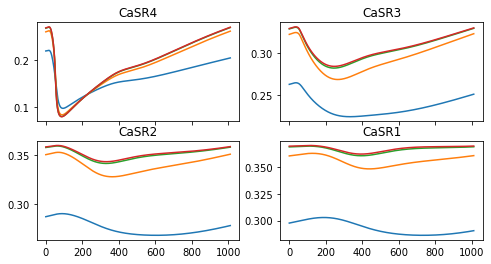

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=plt.figaspect(0.5), sharex=True)

axes = axes.flatten()

for i, df in enumerate(result):
    
    rescale = lambda x: (x - np.min(x)) / np.ptp(x)
    
    for j in range(1, 4+1):
        ax = axes[j-1]
        key = f'CaSR{5-j}'
        ax.plot(df[key])
        #ax.plot(rescale(df[key]))
        ax.set_title(key)

([<matplotlib.axis.XTick at 0x7f7e84b59940>,
 [Text(0, 0, '0.1'), Text(1, 0, '1'), Text(2, 0, '10'), Text(3, 0, '100')])

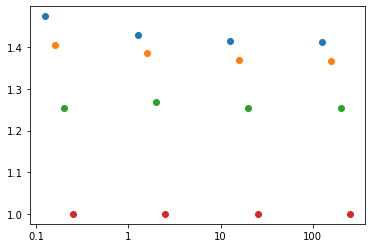

In [55]:
for i, df in enumerate(result):
    for j in range(1, 4+1):
        key = f'CaSR{j}'
        y = df[key].iloc[-1] / df[f'CaSR4'].iloc[-1]
        plt.plot(i+0.1*j, y, 'o', color=f'C{j-1}')
        #ax.plot(rescale(df[key]))
        #ax.set_title(key)
        
plt.xticks(range(len(rel_range)), rel_range)

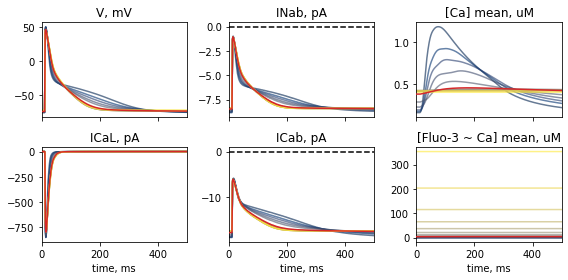

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=plt.figaspect(0.5), sharex=True)

cmap = cm.cividis

for i, df in enumerate(result):

    color = cmap(i / (len(result) - 1))
    
    kw = dict(color=color, alpha=0.6, zorder=0) if i != 5 else dict(color='C3', alpha=1, zorder=10)
    
    axes[0, 0].plot(df.V, **kw)
    axes[0, 2].plot(1e3 * df.Cai_mean, **kw)
    axes[1, 2].plot(1e3 * df.fluo_mean, **kw)
    
for i, df in enumerate(result_A):

    color = cmap(i / (len(result_A) - 1))
    
    kw = dict(color=color, alpha=0.6, zorder=0) if i != 5 else dict(color='C3', alpha=1, zorder=10)

    axes[1, 0].plot(df.I_ICaL, **kw)
    axes[0, 1].plot(df.I_INab, **kw)
    axes[1, 1].plot(df.I_ICab, **kw)
    
axes[0, 1].axhline(0, ls='--', color='k')
axes[1, 1].axhline(0, ls='--', color='k')

titles = [['V, mV', 'INab, pA', '[Ca] mean, uM'],
          ['ICaL, pA', 'ICab, pA', '[Fluo-3 ~ Ca] mean, uM']]

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        ax.set_title(titles[i][j])
        if i:
            ax.set_xlabel('time, ms')
        
    
plt.xlim(0, 500)

plt.tight_layout()

# plt.savefig("../images/fluo/koivumaki_slides_2.png", dpi=600)

In [10]:
result[0].fluo_mean *= 0

In [11]:
result_short = [result[0], result[1], result[5], result[9]]
fluo_short = [fluo_tot_range[0], fluo_tot_range[1], fluo_tot_range[5], fluo_tot_range[9]]

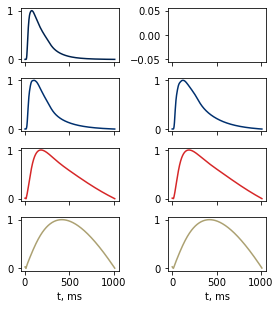

In [12]:
indices = [0, 1, 5, 9]

cmap = cm.cividis

fig, axes = plt.subplots(nrows=len(indices), ncols=2,
                         figsize=plt.figaspect(1.1), sharex=True)

rescale = lambda x: (x - np.min(x)) / np.ptp(x)
#rescale = lambda x: x * 1000

for i_ax, i in enumerate(indices): # , (a, fluo) in enumerate(zip(result_short, fluo_short)):
    
    a = result[i].copy()
    fluo = fluo_tot_range[i]
    
    #kw = dict(color=color, alpha=0.6, zorder=0) if i != 5 else dict(color='C3', alpha=1, zorder=10)
    
    color = cmap(i / (len(result_A) - 1))

#     axes[i_ax, 0].plot(1e3 * a.Cai_mean, color=color if i_ax != 2 else 'C3')
#     axes[i_ax, 1].plot(1e3 * a.fluo_mean, color=color if i_ax != 2 else 'C3')
    
    axes[i_ax, 0].plot(rescale(a.Cai_mean), color=color if i_ax != 2 else 'C3')
    axes[i_ax, 1].plot(rescale(a.fluo_mean), color=color if i_ax != 2 else 'C3')
    
#     axes[i_ax, 1].set_title("[Fluo-3] = {} uM{}".format(int(fluo * 1e3), "\n(Vanessa)" if i_ax == 2 else ""), size='x-small')
    
# axes[0, 0].set_title('[Ca] mean, uM')
# axes[0, 1].set_title('[Fluo-3 ~ Ca] mean, uM')

for i in range(2):
    axes[-1, i].set_xlabel('t, ms')
    
plt.tight_layout()

#plt.savefig("../images/fluo/koivumaki_ca_fluo.png", dpi=600, bbox_inches='tight')

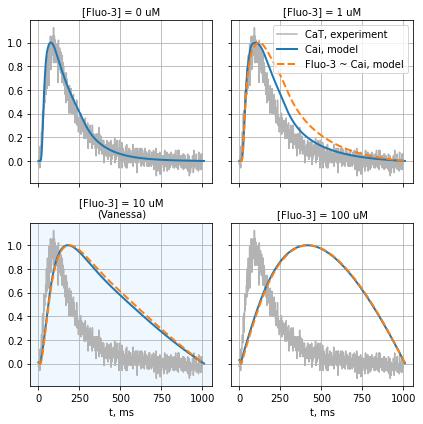

In [52]:
indices = [0, 1, 5, 9]

cmap = cm.cividis

fig, axes = plt.subplots(ncols=2, nrows=2, # len(indices)
                         figsize=(6, 6),
                         sharex=True, sharey=True)

axes = axes.flatten()

cat_voigt = pd.read_csv("../misc/cat_voigt_1_2.csv").iloc[:, 0]

rescale = lambda x: (x - np.min(x)) / np.ptp(x)

for i_ax, i in enumerate(indices):
    
    ax = axes[i_ax]
    
    a = result[i].copy()
    fluo = fluo_tot_range[i]
        
    color = cmap(i / (len(result_A) - 1))

    ax.plot(rescale(cat_voigt)*1.25 - 0.125, color='0.7', label='CaT, experiment')
    
    ax.plot(rescale(a.Cai_mean), color='C0', label='Cai, model', lw=2)
    ax.plot(rescale(a.fluo_mean), '--', color='C1', label='Fluo-3 ~ Cai, model', lw=2)
    
    if i_ax == 1:
        ax.legend()
        
    if i_ax == 2:
        ax.set_facecolor('aliceblue')
    
    ax.set_title("[Fluo-3] = {} uM{}".format(int(fluo * 1e3), "\n(Vanessa)" if i_ax == 2 else ""), size='medium')
    
# axes[0, 0].set_title('[Ca] mean, uM')
# axes[0, 1].set_title('[Fluo-3 ~ Ca] mean, uM')

    if i_ax >= 2:
        ax.set_xlabel('t, ms')
    
for ax in axes.flatten():
    ax.set_xticks(np.linspace(0, 1000, 5))
    ax.grid()
    
plt.tight_layout()

plt.savefig("../images/fluo/koivumaki_ca_fluo.png", dpi=600, bbox_inches='tight')

In [70]:
df = result[5]

In [71]:
df

name,CaSR1,CaSR2,CaSR3,CaSR4,Cai1,Cai2,Cai3,Cai4,Cass,d,...,serca_ass,Nai,Nass,fluo_1,fluo_2,fluo_3,fluo_4,fluo_ss,Cai_mean,fluo_mean
0,2.020198,2.016409,2.008904,1.996886,0.000378,0.000380,0.000383,0.000388,0.000382,0.000012,...,0.022575,11.082181,11.099273,0.003375,0.003387,0.003408,0.003437,0.003404,0.000384,0.003415
1,2.020216,2.016434,2.008942,1.996950,0.000378,0.000380,0.000383,0.000388,0.000382,0.000012,...,0.022575,11.082181,11.098827,0.003375,0.003386,0.003407,0.003436,0.003404,0.000384,0.003414
2,2.020235,2.016458,2.008980,1.997015,0.000378,0.000380,0.000383,0.000388,0.000382,0.000012,...,0.022576,11.082181,11.098382,0.003375,0.003386,0.003407,0.003436,0.003403,0.000384,0.003414
3,2.020253,2.016483,2.009018,1.997079,0.000378,0.000379,0.000383,0.000388,0.000382,0.000012,...,0.022576,11.082181,11.097936,0.003375,0.003386,0.003407,0.003435,0.003402,0.000384,0.003413
4,2.020272,2.016507,2.009056,1.997143,0.000378,0.000379,0.000383,0.000388,0.000382,0.000012,...,0.022576,11.082182,11.097489,0.003374,0.003386,0.003406,0.003435,0.003402,0.000384,0.003413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,2.020302,2.016549,2.009124,1.997263,0.000377,0.000379,0.000383,0.000387,0.000382,0.000012,...,0.022576,11.082380,11.096724,0.003374,0.003385,0.003406,0.003434,0.003401,0.000384,0.003412
1007,2.020320,2.016573,2.009162,1.997327,0.000377,0.000379,0.000383,0.000387,0.000382,0.000012,...,0.022576,11.082380,11.096277,0.003374,0.003385,0.003405,0.003433,0.003400,0.000384,0.003412
1008,2.020338,2.016597,2.009199,1.997390,0.000377,0.000379,0.000383,0.000387,0.000382,0.000012,...,0.022576,11.082380,11.095830,0.003374,0.003385,0.003405,0.003433,0.003400,0.000384,0.003411
1009,2.020357,2.016621,2.009237,1.997454,0.000377,0.000379,0.000383,0.000387,0.000381,0.000012,...,0.022576,11.082380,11.095383,0.003374,0.003385,0.003405,0.003432,0.003399,0.000384,0.003411


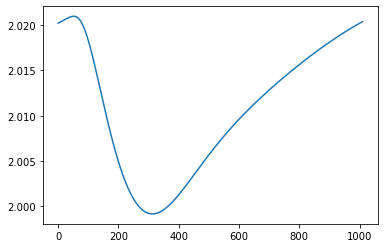

In [72]:
plt.plot(result[5].CaSR1)

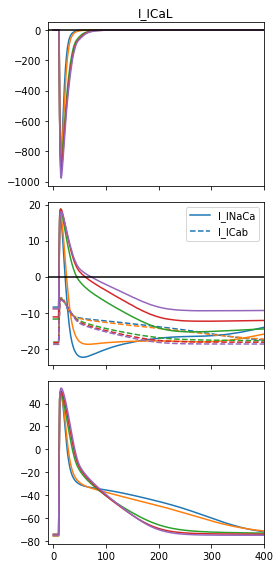

In [137]:
#columns = 'I_ICaL', 'I_INaCa', 'I_ICaP', 'I_ICab'

fig, axes = plt.subplots(nrows=3, figsize=plt.figaspect(2), sharex=True)

plt.sca(axes[0])

for a in result_A:
    plt.plot(a['I_ICaL'])

plt.axhline(0, color='k')
plt.title('I_ICaL')

plt.sca(axes[1])
    
for i, a in enumerate(result_A):
    for j, c in enumerate(['I_INaCa', 'I_ICab']): 
        plt.plot(a[c], ['-', '--'][j], color=f'C{i}', label=c)
    if i == 0:
        plt.legend()
#plt.legend()    
plt.axhline(0, color='k')
    
plt.sca(axes[2])
    
for a in result:
    plt.plot(a['V'])
    
plt.xlim(-10, 400)

fig.align_labels()
plt.tight_layout()

plt.savefig("../images/fluo/koivumaki_currents.png", dpi=600)
plt.show()

In [5]:
volumes = legend_constants[[f'VSR{i}' for i in range(1, 4 + 1)]]

concentrations = legend_states[[f'CaSR{i}' for i in range(1, 4 + 1)]]
CaSR = (concentrations.values * volumes.values).sum() / sum(volumes)

In [6]:
CaSR

0.5881948625

In [7]:
volumes = legend_constants[['Vss'] + [f'Vnonjunct{i}' for i in range(1, 4 + 1)]]

concentrations = legend_states[['Cass'] + [f'Cai{i}' for i in range(1, 4 + 1)]]
Cai = (concentrations.values * volumes.values).sum() / sum(volumes)

In [8]:
Cai

0.0001478528779685226

In [10]:
volumes = legend_constants[['Vss'] + [f'Vnonjunct{i}' for i in range(1, 4 + 1)]]

concentrations = legend_states[['fluo_ss'] + [f'fluo_{i}' for i in range(1, 4 + 1)]]
fluo = (concentrations.values * volumes.values).sum() / sum(volumes)

fluo

0.0016617694556829907

In [8]:
volumes = legend_constants[['Vss'] + [f'Vnonjunct{i}' for i in range(1, 4 + 1)]]

concentrations = output[['Cass'] + [f'Cai{i}' for i in range(1, 4 + 1)]]
Cai_mean = (concentrations.values * volumes.values).sum(axis=1) / sum(volumes)

concentrations = output[['fluo_ss'] + [f'fluo_{i}' for i in range(1, 4 + 1)]]
fluo_mean = (concentrations.values * volumes.values).sum(axis=1) / sum(volumes)

output['Cai_mean'] = Cai_mean
output['fluo_mean'] = fluo_mean

# Fluo-3

In [64]:
fluo_range = np.logspace(-3, -1, 10)
fluo_range

array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ])

In [65]:
result = []

t_sampling = 0.001

CL = 1000
C['STIM_PERIOD'] = CL / 1000
stim_period = C['STIM_PERIOD']
n_samples_per_stim = int(stim_period / t_sampling)

n_beats = 1000
tol = 1e-5

output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))
output_A = np.zeros((n_samples_per_stim * n_beats + 1, len(A)))
t = np.zeros(n_samples_per_stim * n_beats + 1)

output = pd.DataFrame(output, columns=legend_states.index)
output_A = pd.DataFrame(output_A, columns=legend_algebraic.index)
    
for C['fluo_tot'] in fluo_range:

    status = model.run_algebraic(S.values.copy(), C.values,
                                 n_beats, t_sampling, tol, output.values,
                                 output_A.values, t)
    print(status)
    
    result.append([output[-1001:].copy(), output_A[-1001:].copy()])

2
2
2
2
2
2
2
2
2
2


In [66]:
err_abs = output.iloc[-1] - output.iloc[-CL - 1]
err_rel = err_abs / output.iloc[-CL - 1] * 100

items = ['Nai', 'Ki', 'V', 'Cai']
# items = ['Nai', 'Ki']

df_err= pd.DataFrame([err_rel[items], err_abs[items]],
                     index=['err_rel', 'err_abs'])
df_err

name,Nai,Ki,V,Cai
err_rel,0.002593,-0.000214,0.000186,1.580525e-03
err_abs,0.000289,-0.000281,-0.000138,6.716594e-09


In [67]:
from matplotlib import cm

cmap = cm.viridis

In [52]:
rescale = lambda x: (x - np.min(x)) / np.ptp(x)

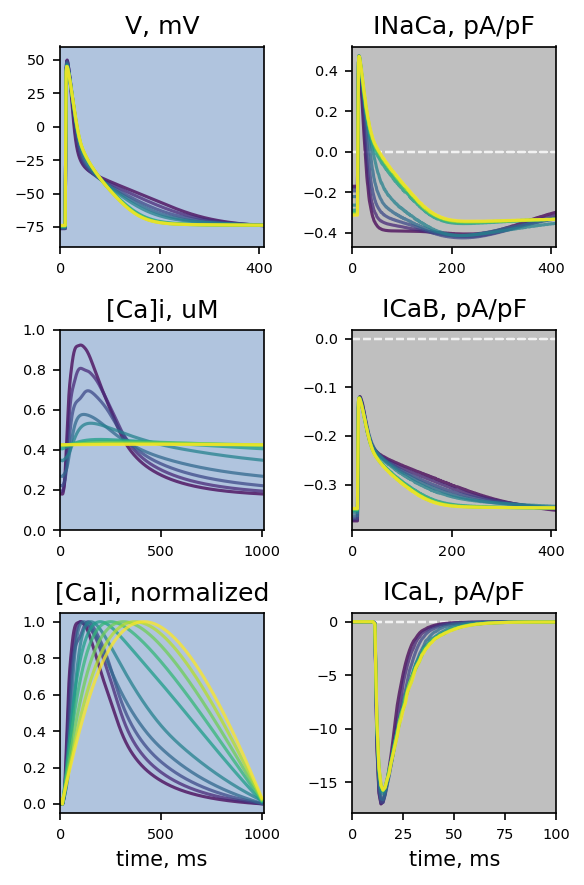

In [93]:
fig, axes = plt.subplots(nrows=3, ncols=2,
                         figsize=plt.figaspect(3 / 2),
                         #sharex=True,
                         dpi=150)

axes = axes.T.flatten()

keys = ['V', 'Cai', 'Cai', 'I_INaCa', 'I_ICab', 'I_ICaL']

titles = ['V, mV', '[Ca]i, uM', '[Ca]i, normalized', 'INaCa, pA/pF', 'ICaB, pA/pF', 'ICaL, pA/pF']

xlims = [(0, 410),
         (0, 1010),
         (0, 1010),
         (0, 410),
         (0, 410),
         (0, 100),]

for i_key, (key, ax) in enumerate(zip(keys, axes)):
    for i_pair, pair in enumerate(result):
        for df in pair:
            if key in df:
                
                x = df[key].values.copy()
                x = np.roll(x, 10)
                
                if key.startswith('I'):
                    ax.axhline(0, ls='--', color='0.95', lw=1, zorder=-1)
                    x /= 50 # pF
                    
                if key == 'Cai':
                    x *= 1000
                    if i_key == 2:
                        x = rescale(x)
                
                if False: # fluo_range[i_pair] == 0.01:
                    color = 'C3'
                    zorder = 10
                else:
                    color = cmap(i_pair / (len(result) - 1))
                    zorder = 0
                    
                ax.plot(x, color=color, alpha=0.75, zorder=zorder)
                ax.set_title(key)
                    
                ax.set_title(titles[i_key])
                
                facecolor = 'lightsteelblue' if i_key <= 2 else '0.75'
                ax.set_facecolor(facecolor)
                
                #ax.set_xticks(np.arange(0, 650, 100))
                
                ax.tick_params(labelsize='x-small')
                
                if ax.is_last_row():
                    ax.set_xlabel('time, ms')
                    
                ax.set_xlim(xlims[i_key])
                
                if key == 'V':
                    ax.set_ylim(-90, 60)
                    
                if i_key == 1:
                    ax.set_ylim(0, 1)
                    
plt.tight_layout()

plt.savefig("../images/fluo/koivumaki_currents_v2.png")